# Applying Temporal Convonotional Networks to the Virtual Flow Metering Problem (Testing Robustness) 

## Author: Ridha Alkhabaz 

### Imports:

In [1]:
### to hide warning messages:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
### to build the TCN model 
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing import sequence
from tcn import TCN, compiled_tcn
import tensorflow as tf
import os
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/ElectricDemandForecasting-DL/src/")
from models import tcn
# for data configurations
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm

### Data configuration and Reading:

#### First: Riser data:

##### Reading the data and formating:

In [2]:
# Convert the sequence of seconds into datetime array
### TODO: DEBUG
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z
# the following are functions to observe the robustness of our model 
def spikes_addition(data, num_points=0, is_well=False):
    # some outliers and spikes
    for i in random.sample(range(0, len(data)), num_points):
        data[i][1] = np.random.uniform(data[:,1].min(),data[:,1].max())
        data[i][2] = np.random.uniform(data[:,2].min(),data[:,2].max())
        data[i][3] = np.random.uniform(data[:,3].min(),data[:,3].max())
        data[i][4] = np.random.uniform(data[:,4].min(),data[:,4].max())
        data[i][5] = np.random.uniform(data[:,5].min(),data[:,5].max())
        if is_well:
            continue
        data[i][6] = np.random.uniform(data[:,6].min(),data[:,6].max())
        data[i][7] = np.random.uniform(data[:,7].min(),data[:,7].max())
        data[i][8] = np.random.uniform(data[:,8].min(),data[:,8].max())
        data[i][9] = np.random.uniform(data[:,9].min(),data[:,9].max())
    return data
def gaussian_noise_addition(data, mu=0, sigma=0.005):
    ## adding noise after normalization 
    noise = np.random.normal(mu, sigma, data[:, 1:].shape)
    data[:, 1:] = data[:, 1:] + noise
    return data
def random_missing_data(data, num_points=0, is_well=False):
    from random import randint
    index = [randint(0, len(data)) for i in range(num_points)]
    if is_well:
        data[index, 1:6] = 0
    else:
        data[index, 1:10] = 0
    return data, index

In [3]:
# Read the data from fname and eventually plot them
def read_data(fname, params=[0, 0, 5e-3, 0]):
    # Read the time serie
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values
    # Adding spikes:
    data = spikes_addition(data, num_points=int(params[0]))
    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)
    # Adding gaussian noise
    data = gaussian_noise_addition(data, mu=params[1], sigma=params[2])
    
    # Removing some points:
    data, _ = random_missing_data(data, num_points=int(params[3]))

    return data, scaler

##### Sliding window technique (Data configuration):


In [16]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
data_riser, _= read_data('riser_pq_uni.csv', params=np.array([10, 0, 5e-3, 10]))
df_riser = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data_riser.T)))
### previous readings for univariate model 
dt_gas_riser = np.array(df_riser['gas(m3/day)'])
dt_liquid_riser = np.array(df_riser['liquid(m3/day)'])
### gas and liquid dataframe
df_gas_riser = df_riser.drop('liquid(m3/day)', axis=1)
df_gas_riser = df_gas_riser.set_index('ds')
df_liquid_riser = df_riser.drop('gas(m3/day)', axis=1)
df_liquid_riser = df_liquid_riser.set_index('ds')

###### Some visualization for the data:

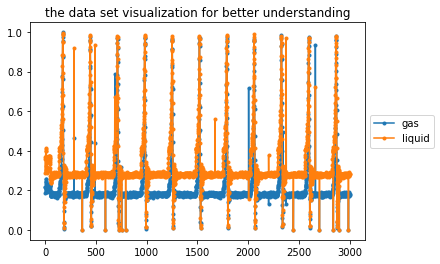

In [17]:
df_riser = df_riser.reset_index()
fig,ax = plt.subplots()
ax.set_title('the data set visualization for better understanding')
ax.plot(df_riser['ds'], df_riser['gas(m3/day)'], marker=".", label='gas')
ax.plot(df_riser['ds'], df_riser['liquid(m3/day)'], marker=".", label='liquid')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_riser = df_riser.set_index('ds')

##### Model Construction and Hyperparameters:

In [18]:
# Model Hyperparemeters (general hyperparameters)
FORECAST_HORIZON = 5 #secs 
PAST_HISTORY = 300
BATCH_SIZE = 64
EPOCHS = 100

#### GAS (models)
##### Univariate Model:

In [19]:
INPUT_DIMSION = 1
model_gas_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_uni.summary()
model_gas_uni.compile('adam', 'mse')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                136256    
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


##### Multivariate Model:

In [20]:
INPUT_DIMSION = 8 # we include pressure readings and past observations of gas flow rate 
model_gas_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_mult.summary()
model_gas_mult.compile('adam', 'mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                138048    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 138,373
Trainable params: 138,373
Non-trainable params: 0
_________________________________________________________________


#### Liquid Models:
##### Univariate Model:

In [21]:
INPUT_DIMSION = 1
model_liq_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_liq_uni.summary()
model_liq_uni.compile('adam', 'mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


##### Multivariate Model:

In [22]:
INPUT_DIMSION = 8
model_liquid_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_liquid_mult.summary()
model_liquid_mult.compile('adam', 'mse')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 64)                138048    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 138,373
Trainable params: 138,373
Non-trainable params: 0
_________________________________________________________________


In [23]:
def univariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    for i in range(start_index, end_index - forecast_horizon + 1):
        indices = range(i - history_size, i, step)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(tseries[indices], (history_size, 1)))

        if single_step:
            labels.append(tseries[i + forecast_horizon])
        else:
            labels.append(tseries[i:i + forecast_horizon])

    return np.array(data), np.array(labels)
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size +1, forecast_horizon):
        end = i+history_size
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+forecast_horizon, 7:])
    return np.array(data), np.array(labels)

In [24]:
def configure(data, params = [0, 1500, 2500, 3000], multi = False):
    if multi:
        x_mult, y_mult= multivariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON)
        valX_mult , valY_mult = multivariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON)
        testX_mult, testY_mult = multivariate_data(np.array(data), params[2], params[3]-1, PAST_HISTORY, FORECAST_HORIZON)
        # to avoid combatibility issues
        x_mult = x_mult.astype(np.float32)
        y_mult = y_mult.astype(np.float32)
        valX_mult = valX_mult.astype(np.float32)
        valY_mult = valY_mult.astype(np.float32)
        testX_mult = testX_mult.astype(np.float32)
        testY_mult = testY_mult.astype(np.float32)
        # to build data set
        train_data_mult = tf.data.Dataset.from_tensor_slices((x_mult, y_mult)).cache().batch(BATCH_SIZE).repeat()
        val_data_mult = tf.data.Dataset.from_tensor_slices((valX_mult, valY_mult)).batch(BATCH_SIZE).repeat()
        return train_data_mult, val_data_mult, testX_mult, testY_mult
    # for univariate 
    x_uni, y_uni = univariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON, single_step=False)
    valX_uni , valY_uni = univariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON, step=1, single_step=False)
    testX_uni, testY_uni = univariate_data(np.array(data),params[2], params[3], PAST_HISTORY, FORECAST_HORIZON, step=1, single_step=False)
    # to avoid combatibality issues
    x_uni = x_uni.astype(np.float32)
    y_uni = y_uni.astype(np.float32)
    valX_uni = valX_uni.astype(np.float32)
    valY_uni = valY_uni.astype(np.float32)
    testX_uni = testX_uni.astype(np.float32)
    testY_uni = testY_uni.astype(np.float32)
    # to build data set 
    train_data_uni = tf.data.Dataset.from_tensor_slices((x_uni, y_uni)).cache().batch(BATCH_SIZE).repeat()
    val_data_uni = tf.data.Dataset.from_tensor_slices((valX_uni, valY_uni)).batch(BATCH_SIZE).repeat()
    return train_data_uni, val_data_uni, testX_uni, testY_uni
    

In [25]:
# gas (uni)
gas_uni_train, gas_uni_val , gas_uni_testX, gas_uni_testY = configure(dt_gas_riser,params = [0, 1500, 2500, 3000], multi = False)
gas_mult_train, gas_mult_val , gas_mult_testX, gas_mult_testY = configure(df_gas_riser,params = [0, 1500, 2500, 3000], multi = True)
# liquid (uni)
liq_uni_train, liq_uni_val, liq_uni_testX, liq_uni_testY = configure(dt_liquid_riser,params = [0, 1500, 2500, 3000], multi = False)
liq_mult_train, liq_mult_val, liq_mult_testX, liq_mult_testY = configure(df_liquid_riser,params = [0, 1500, 2500, 3000], multi = True)

In [26]:
##gas 
### univariate
evaluation_interval = 10
history_gas_uni = model_gas_uni.fit(gas_uni_train, epochs=50, steps_per_epoch=evaluation_interval, validation_data=gas_uni_val, validation_steps=evaluation_interval)

Epoch 1/50
10/10 [==============================] - 15s 1s/step - loss: 4.6488 - val_loss: 0.4207
Epoch 2/50
10/10 [==============================] - 7s 712ms/step - loss: 0.3395 - val_loss: 0.1493
Epoch 3/50
10/10 [==============================] - 7s 717ms/step - loss: 0.1156 - val_loss: 0.0597
Epoch 4/50
10/10 [==============================] - 6s 635ms/step - loss: 0.0439 - val_loss: 0.0367
Epoch 5/50
10/10 [==============================] - 6s 614ms/step - loss: 0.0417 - val_loss: 0.0236
Epoch 6/50
10/10 [==============================] - 6s 594ms/step - loss: 0.0144 - val_loss: 0.0193
Epoch 7/50
10/10 [==============================] - 6s 578ms/step - loss: 0.0192 - val_loss: 0.0160
Epoch 8/50
10/10 [==============================] - 6s 592ms/step - loss: 0.0086 - val_loss: 0.0140
Epoch 9/50
10/10 [==============================] - 7s 718ms/step - loss: 0.0145 - val_loss: 0.0129
Epoch 10/50
10/10 [==============================] - 7s 689ms/step - loss: 0.0081 - val_loss: 0.0115
E

In [28]:
### multivariate 
evaluation_interval = 10
history_gas_mult = model_gas_mult.fit(gas_mult_train, epochs=50, steps_per_epoch=evaluation_interval,\
                                    validation_data=gas_mult_val, validation_steps=evaluation_interval)

Epoch 1/50
10/10 [==============================] - 6s 609ms/step - loss: 2.9726 - val_loss: 0.6158
Epoch 2/50
10/10 [==============================] - 6s 642ms/step - loss: 0.3138 - val_loss: 0.1699
Epoch 3/50
10/10 [==============================] - 6s 626ms/step - loss: 0.1186 - val_loss: 0.0753
Epoch 4/50
10/10 [==============================] - 7s 718ms/step - loss: 0.0697 - val_loss: 0.0628
Epoch 5/50
10/10 [==============================] - 7s 723ms/step - loss: 0.0544 - val_loss: 0.0384
Epoch 6/50
10/10 [==============================] - 6s 648ms/step - loss: 0.0358 - val_loss: 0.0294
Epoch 7/50
10/10 [==============================] - 7s 715ms/step - loss: 0.0328 - val_loss: 0.0264
Epoch 8/50
10/10 [==============================] - 7s 671ms/step - loss: 0.0230 - val_loss: 0.0211
Epoch 9/50
10/10 [==============================] - 7s 695ms/step - loss: 0.0225 - val_loss: 0.0191
Epoch 10/50
10/10 [==============================] - 6s 656ms/step - loss: 0.0177 - val_loss: 0.0181

In [29]:
##liq
## univariate 
evaluation_interval = 10
history_liq_uni = model_liq_uni.fit(liq_uni_train, epochs=50, steps_per_epoch=evaluation_interval, \
                                    validation_data=liq_uni_val, validation_steps=evaluation_interval)

Epoch 1/50
10/10 [==============================] - 8s 607ms/step - loss: 24.3321 - val_loss: 1.1410
Epoch 2/50
10/10 [==============================] - 6s 636ms/step - loss: 1.0961 - val_loss: 0.4358
Epoch 3/50
10/10 [==============================] - 8s 775ms/step - loss: 0.3131 - val_loss: 0.1839
Epoch 4/50
10/10 [==============================] - 7s 746ms/step - loss: 0.1532 - val_loss: 0.1010
Epoch 5/50
10/10 [==============================] - 8s 785ms/step - loss: 0.1189 - val_loss: 0.0633
Epoch 6/50
10/10 [==============================] - 7s 702ms/step - loss: 0.0500 - val_loss: 0.0500
Epoch 7/50
10/10 [==============================] - 7s 725ms/step - loss: 0.0663 - val_loss: 0.0390
Epoch 8/50
10/10 [==============================] - 7s 713ms/step - loss: 0.0302 - val_loss: 0.0341
Epoch 9/50
10/10 [==============================] - 8s 808ms/step - loss: 0.0360 - val_loss: 0.0295
Epoch 10/50
10/10 [==============================] - 7s 762ms/step - loss: 0.0253 - val_loss: 0.026

In [30]:
##liq
## multivariate 
evaluation_interval = 10
history_liq_mult = model_liquid_mult.fit(liq_mult_train, epochs=50, steps_per_epoch=evaluation_interval, \
                                    validation_data=liq_mult_val, validation_steps=evaluation_interval)

Epoch 1/50
10/10 [==============================] - 8s 562ms/step - loss: 45.9240 - val_loss: 0.5813
Epoch 2/50
10/10 [==============================] - 6s 637ms/step - loss: 0.5251 - val_loss: 0.2510
Epoch 3/50
10/10 [==============================] - 7s 677ms/step - loss: 0.1692 - val_loss: 0.0598
Epoch 4/50
10/10 [==============================] - 6s 638ms/step - loss: 0.0663 - val_loss: 0.0475
Epoch 5/50
10/10 [==============================] - 6s 635ms/step - loss: 0.0506 - val_loss: 0.0311
Epoch 6/50
10/10 [==============================] - 6s 639ms/step - loss: 0.0316 - val_loss: 0.0275
Epoch 7/50
10/10 [==============================] - 6s 650ms/step - loss: 0.0306 - val_loss: 0.0222
Epoch 8/50
10/10 [==============================] - 6s 659ms/step - loss: 0.0218 - val_loss: 0.0192
Epoch 9/50
10/10 [==============================] - 7s 669ms/step - loss: 0.0225 - val_loss: 0.0166
Epoch 10/50
10/10 [==============================] - 6s 658ms/step - loss: 0.0165 - val_loss: 0.014

In [31]:
def mse(real, pred):
    return mean_squared_error(real, pred)

[mse(model_gas_uni.predict(gas_uni_testX).flatten(), gas_uni_testY.flatten()),\
 mse(model_gas_mult.predict(gas_mult_testX).flatten(), gas_mult_testY.flatten()),\
 mse(model_liq_uni.predict(liq_uni_testX).flatten(), liq_uni_testY.flatten()),\
 mse(model_liquid_mult.predict(liq_mult_testX).flatten(), liq_mult_testY.flatten())]

[0.0041684397, 0.021594329, 0.011442358, 0.03203744]

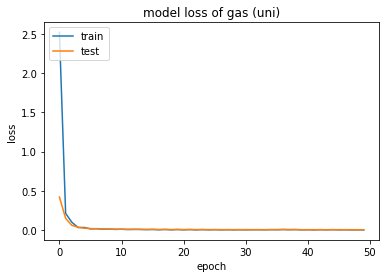

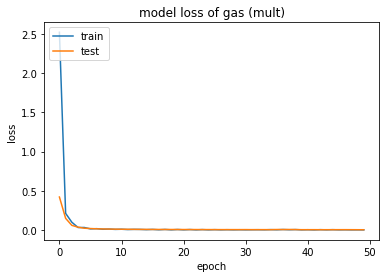

In [32]:
## GAS 
# summarize history for loss
plt.plot(history_gas_uni.history['loss'])
plt.plot(history_gas_uni.history['val_loss'])
plt.title('model loss of gas (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_gas_uni.history['loss'])
plt.plot(history_gas_uni.history['val_loss'])
plt.title('model loss of gas (mult)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

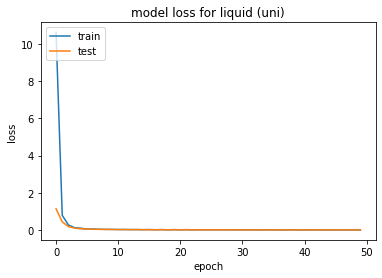

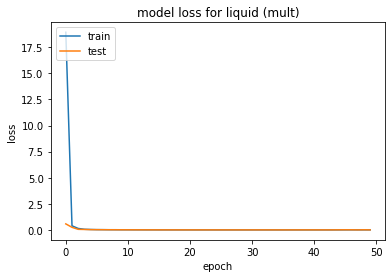

In [33]:
## Liquid 
plt.plot(history_liq_uni.history['loss'])
plt.plot(history_liq_uni.history['val_loss'])
plt.title('model loss for liquid (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_liq_mult.history['loss'])
plt.plot(history_liq_mult.history['val_loss'])
plt.title('model loss for liquid (mult)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
## gas testing data set visualization
### univariate 
real_gas_uni = gas_uni_testY.flatten()
pred_gas_uni = model_gas_uni.predict(gas_uni_testX).flatten()
df_plot_gas_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_gas_uni['ds']=range(0,len(real_gas_uni))
### multivariate 
real_gas_mult = gas_mult_testY.flatten()
pred_gas_mult = model_gas_mult.predict(gas_mult_testX).flatten()
df_plot_gas_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult, real_gas_mult]))))
df_plot_gas_mult['ds']=range(0,len(real_gas_mult))
##liquid
## univariate
real_liq_uni = liq_uni_testY.flatten()
pred_liq_uni = model_liq_uni.predict(liq_uni_testX).flatten()
df_plot_liq_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_liq_uni['ds']=range(0,len(real_liq_uni))
## multivariate 
real_liq_mult = liq_mult_testY.flatten()
pred_liq_mult = model_liquid_mult.predict(liq_mult_testX).flatten()
df_plot_liq_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_mult, real_liq_mult]))))
df_plot_liq_mult['ds']=range(0,len(real_liq_mult))

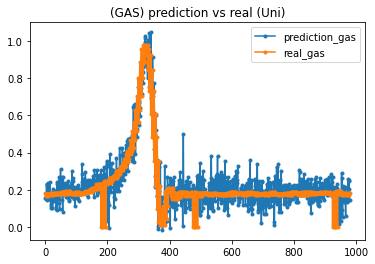

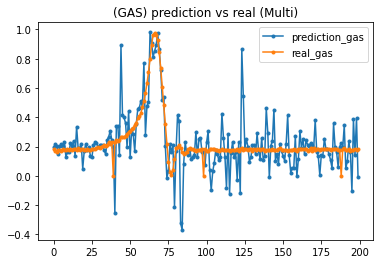

In [35]:
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Uni)')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

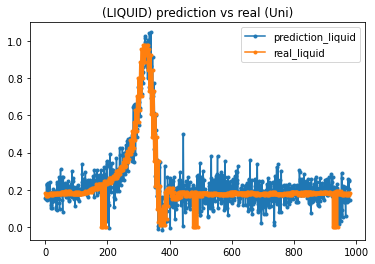

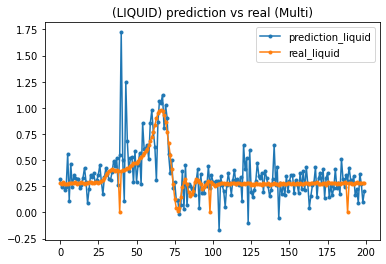

In [36]:
### liquid before noise, removed data and spikes 
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(LIQUID) prediction vs real (Uni)')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['prediction'].iloc[start:end], marker=".", label='prediction_liquid')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['real'].iloc[start:end], marker=".", label='real_liquid')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(LIQUID) prediction vs real (Multi)')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['prediction'].iloc[start:end], marker=".", label='prediction_liquid')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['real'].iloc[start:end], marker=".", label='real_liquid')
ax.legend()

#### Well data

In [47]:
def read_data(fname, params=[10, 0, 5e-3, 10]):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1   
    for n in range(Nfp):
        fp[n] = spikes_addition(fp[n], num_points=params[0], is_well=True)
    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
#         fp[n] = spikes_addition(fp[n], num_points=params[0], is_well=True)
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])
    #adding some gaussian noise 
        fp[n][:,:] = gaussian_noise_addition(fp[n][:,:], mu=params[1], sigma=params[2])
    
    # Removing some points:
        fp[n][:,:], _ = random_missing_data(fp[n][:,:], num_points=int(params[3]), is_well=True)

    return fp, headers, scaler

In [48]:
fp,headers, _ = read_data('welltest.csv')

In [61]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
fp, headers, scaler = read_data('welltest.csv')
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
for i in [1,2, 3, 4]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df = df.drop(['DateTime'], axis=1)
# test = pd.DataFrame.from_dict(dict(zip(headers, fp[3].T)))
# test = test.drop(['DateTime'], axis=1)
## univariate training
train_uni_oil= np.array(df['Qo (m3/day)'])
train_uni_water= np.array(df['Qw (m3/day)']) 
train_uni_gas= np.array(df['Qg (m3/day)']) 
## multivariate 
train_mult_oil = df.iloc[:, 0:3]
train_mult_water = pd.concat([df.iloc[:, 0:2], df['Qw (m3/day)']], axis=1)
train_mult_gas = pd.concat([df.iloc[:, 0:2], df['Qg (m3/day)']], axis=1)

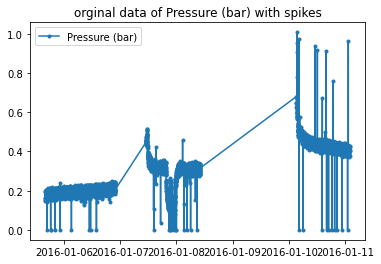

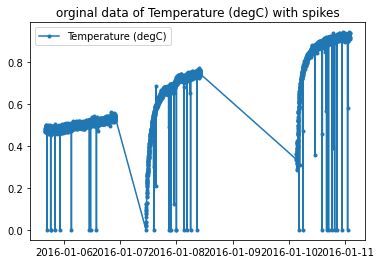

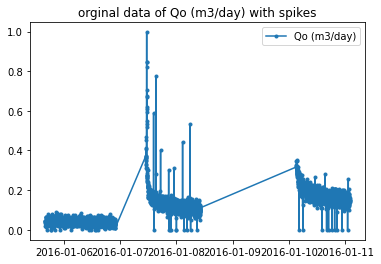

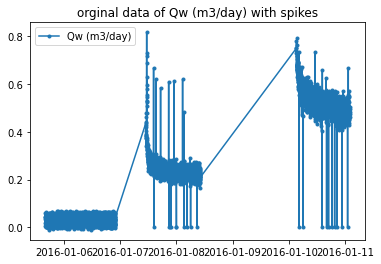

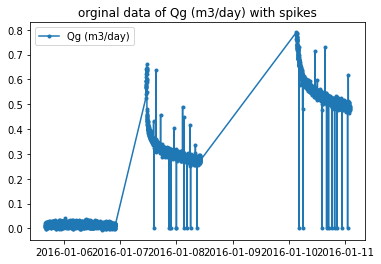

In [50]:
start  = 0
end = len(df)
for i in headers[1:]:
    fig,ax = plt.subplots()
    ax.set_title('orginal data of %s with spikes'%i)
    ax.plot(df['ds'].iloc[start:end], df[i].iloc[start:end], marker=".", label='%s'%i)
    ax.legend()

### Models parameters and structure:

In [52]:
# Model Hyperparemeters (general hyperparameters)
FORECAST_HORIZON = 5 #secs 
PAST_HISTORY = 300
BATCH_SIZE = 64

In [53]:
##  Oil (univariate)
INPUT_DIMSION = 1
model_oil_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_oil_uni.summary()
model_oil_uni.compile('adam', 'mse')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_4 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [54]:
## multivariate 
INPUT_DIMSION = 3
model_oil_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_oil_mult.summary()
model_oil_mult.compile('adam', 'mse')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_5 (TCN)                  (None, 64)                136768    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 137,093
Trainable params: 137,093
Non-trainable params: 0
_________________________________________________________________


In [55]:
##  water (univariate)
INPUT_DIMSION = 1
model_water_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_water_uni.summary()
model_water_uni.compile('adam', 'mse')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_6 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [56]:
##  water (multivariate)
INPUT_DIMSION = 3
model_water_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_water_mult.summary()
model_water_mult.compile('adam', 'mse')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_7 (TCN)                  (None, 64)                136768    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 137,093
Trainable params: 137,093
Non-trainable params: 0
_________________________________________________________________


In [57]:
##  gas (univariate)
INPUT_DIMSION = 1
model_gas_uni = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_uni.summary()
model_gas_uni.compile('adam', 'mse')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_8 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [58]:
##  gas (multivariate)
INPUT_DIMSION = 3
model_gas_mult = Sequential(
    layers=[
        TCN(input_shape=(PAST_HISTORY, INPUT_DIMSION)),  # output.shape = (batch, 64)
        Dense(FORECAST_HORIZON) # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_mult.summary()
model_gas_mult.compile('adam', 'mse')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_9 (TCN)                  (None, 64)                136768    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 137,093
Trainable params: 137,093
Non-trainable params: 0
_________________________________________________________________


#### Data configurations:

In [59]:
def univariate_data(tseries, start_index, end_index, history_size, forecast_horizon, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    for i in range(start_index, end_index - forecast_horizon + 1, forecast_horizon):
        end = i+history_size
        if len(tseries[i:end]) < history_size:
            break
        data.append(tseries[i:end].reshape(history_size, 1))
        labels.append(tseries[i:i + forecast_horizon])

    return np.array(data), np.array(labels)
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size, forecast_horizon):
        end = i+history_size
        if len(tseries[end:end+forecast_horizon, 2:]) <5:
            break
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+forecast_horizon, 2:])
    return np.array(data), np.array(labels)

def configure(data, params = [0, 4557, 5535, 7933], multi = False):
    if multi:
        x_mult, y_mult= multivariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON)
        valX_mult , valY_mult = multivariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON)
        testX_mult, testY_mult = multivariate_data(np.array(data), params[2], params[3], PAST_HISTORY, FORECAST_HORIZON)
        # to avoid combatibility issues
        x_mult = x_mult.astype(np.float32)
        y_mult = y_mult.astype(np.float32)
        valX_mult = valX_mult.astype(np.float32)
        valY_mult = valY_mult.astype(np.float32)
        testX_mult = testX_mult.astype(np.float32)
        testY_mult = testY_mult.astype(np.float32)
        # to build data set
        train_data_mult = tf.data.Dataset.from_tensor_slices((x_mult, y_mult)).cache().batch(BATCH_SIZE).repeat()
        val_data_mult = tf.data.Dataset.from_tensor_slices((valX_mult, valY_mult)).batch(BATCH_SIZE).repeat()
        return train_data_mult, val_data_mult, testX_mult, testY_mult
    # for univariate 
    x_uni, y_uni = univariate_data(np.array(data), params[0], params[1], PAST_HISTORY, FORECAST_HORIZON)
    valX_uni , valY_uni = univariate_data(np.array(data), params[1], params[2], PAST_HISTORY, FORECAST_HORIZON)
    testX_uni, testY_uni = univariate_data(np.array(data),params[2], params[3], PAST_HISTORY, FORECAST_HORIZON)
    # to avoid combatibality issues
    x_uni = x_uni.astype(np.float32)
    y_uni = y_uni.astype(np.float32)
    valX_uni = valX_uni.astype(np.float32)
    valY_uni = valY_uni.astype(np.float32)
    testX_uni = testX_uni.astype(np.float32)
    testY_uni = testY_uni.astype(np.float32)
    # to build data set 
    train_data_uni = tf.data.Dataset.from_tensor_slices((x_uni, y_uni)).cache().batch(BATCH_SIZE).repeat()
    val_data_uni = tf.data.Dataset.from_tensor_slices((valX_uni, valY_uni)).batch(BATCH_SIZE).repeat()
    return train_data_uni, val_data_uni, testX_uni, testY_uni

In [62]:
## Oil
oil_uni_train, oil_uni_val, oil_uni_testX, oil_uni_testY = configure(train_uni_oil, \
                                                                     params = [0, 4557, 5535, 7934], multi = False)
oil_mult_train, oil_mult_val, oil_mult_testX, oil_mult_testY = configure(train_mult_oil,\
                                                                         params = [0, 4557, 5535, 7933], multi = True)
# Water 
water_uni_train, water_uni_val, water_uni_testX, water_uni_testY = configure(train_uni_water, \
                                                                     params = [0, 4557, 5535, 7934], multi = False)
water_mult_train, water_mult_val, water_mult_testX, water_mult_testY = configure(train_mult_water,\
                                                                         params = [0, 4557, 5535, 7933], multi = True)
# Gas
# Water 
gas_uni_train, gas_uni_val, gas_uni_testX, gas_uni_testY = configure(train_uni_gas, \
                                                                     params = [0, 4557, 5535, 7934], multi = False)
gas_mult_train, gas_mult_val, gas_mult_testX, gas_mult_testY = configure(train_mult_gas,\
                                                                         params = [0, 4557, 5535, 7933], multi = True)

#### Model fitting:

In [63]:
## oil 
## univariate
evaluation_interval = 10
history_oil_uni = model_oil_uni.fit(oil_uni_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=oil_uni_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 17s 939ms/step - loss: 0.5889 - val_loss: 0.0471
Epoch 2/100
10/10 [==============================] - 8s 767ms/step - loss: 0.0660 - val_loss: 0.0549
Epoch 3/100
10/10 [==============================] - 10s 963ms/step - loss: 0.0315 - val_loss: 0.0233
Epoch 4/100
10/10 [==============================] - 7s 732ms/step - loss: 0.0261 - val_loss: 0.0074
Epoch 5/100
10/10 [==============================] - 6s 592ms/step - loss: 0.0165 - val_loss: 0.0073
Epoch 6/100
10/10 [==============================] - 5s 522ms/step - loss: 0.0114 - val_loss: 0.0101
Epoch 7/100
10/10 [==============================] - 5s 537ms/step - loss: 0.0173 - val_loss: 0.0047
Epoch 8/100
10/10 [==============================] - 5s 542ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 9/100
10/10 [==============================] - 6s 642ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 10/100
10/10 [==============================] - 6s 627ms/step - loss: 0.0063 - val_

10/10 [==============================] - 8s 864ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 82/100
10/10 [==============================] - 9s 901ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 83/100
10/10 [==============================] - 7s 642ms/step - loss: 0.0027 - val_loss: 0.0074
Epoch 84/100
10/10 [==============================] - 8s 776ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 85/100
10/10 [==============================] - 6s 629ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 86/100
10/10 [==============================] - 7s 667ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 87/100
10/10 [==============================] - 7s 725ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 88/100
10/10 [==============================] - 8s 835ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 89/100
10/10 [==============================] - 8s 870ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 90/100
10/10 [==============================] - 7s 701ms/step - loss: 0.0032 - val_loss: 

In [64]:
## oil 
## multivariate 0try pressure only and tempreture only 
evaluation_interval = 10
history_oil_mult = model_oil_mult.fit(oil_mult_train, epochs=100, steps_per_epoch=evaluation_interval, validation_data=oil_mult_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 13s 858ms/step - loss: 17.5694 - val_loss: 0.6086
Epoch 2/100
10/10 [==============================] - 7s 685ms/step - loss: 0.4986 - val_loss: 0.3136
Epoch 3/100
10/10 [==============================] - 6s 664ms/step - loss: 0.1268 - val_loss: 0.1848
Epoch 4/100
10/10 [==============================] - 7s 739ms/step - loss: 0.0740 - val_loss: 0.0774
Epoch 5/100
10/10 [==============================] - 7s 685ms/step - loss: 0.0401 - val_loss: 0.0668
Epoch 6/100
10/10 [==============================] - 7s 695ms/step - loss: 0.0399 - val_loss: 0.0594
Epoch 7/100
10/10 [==============================] - 7s 673ms/step - loss: 0.0445 - val_loss: 0.0493
Epoch 8/100
10/10 [==============================] - 7s 721ms/step - loss: 0.0195 - val_loss: 0.0624
Epoch 9/100
10/10 [==============================] - 7s 709ms/step - loss: 0.0306 - val_loss: 0.0451
Epoch 10/100
10/10 [==============================] - 10s 1s/step - loss: 0.0385 - val_lo

10/10 [==============================] - 7s 696ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 82/100
10/10 [==============================] - 6s 625ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 83/100
10/10 [==============================] - 6s 647ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 84/100
10/10 [==============================] - 6s 635ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 85/100
10/10 [==============================] - 6s 662ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 86/100
10/10 [==============================] - 6s 600ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 87/100
10/10 [==============================] - 6s 561ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 88/100
10/10 [==============================] - 5s 523ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 89/100
10/10 [==============================] - 5s 510ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 90/100
10/10 [==============================] - 5s 506ms/step - loss: 0.0031 - val_loss: 

In [65]:
## water 
## univariate 
evaluation_interval = 10
history_water_uni = model_water_uni.fit(water_uni_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=water_uni_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 12s 734ms/step - loss: 0.2107 - val_loss: 0.2953
Epoch 2/100
10/10 [==============================] - 6s 596ms/step - loss: 0.1466 - val_loss: 0.4593
Epoch 3/100
10/10 [==============================] - 6s 600ms/step - loss: 0.0851 - val_loss: 0.3877
Epoch 4/100
10/10 [==============================] - 6s 588ms/step - loss: 0.0675 - val_loss: 0.0867
Epoch 5/100
10/10 [==============================] - 5s 526ms/step - loss: 0.0853 - val_loss: 0.2823
Epoch 6/100
10/10 [==============================] - 5s 483ms/step - loss: 0.1174 - val_loss: 0.4150
Epoch 7/100
10/10 [==============================] - 5s 502ms/step - loss: 0.0848 - val_loss: 0.0294
Epoch 8/100
10/10 [==============================] - 5s 525ms/step - loss: 0.0169 - val_loss: 0.0978
Epoch 9/100
10/10 [==============================] - 5s 497ms/step - loss: 0.0379 - val_loss: 0.0891
Epoch 10/100
10/10 [==============================] - 6s 586ms/step - loss: 0.0345 - val_l

10/10 [==============================] - 5s 510ms/step - loss: 0.0075 - val_loss: 0.0266
Epoch 82/100
10/10 [==============================] - 5s 490ms/step - loss: 0.0050 - val_loss: 0.0343
Epoch 83/100
10/10 [==============================] - 5s 497ms/step - loss: 0.0139 - val_loss: 0.0307
Epoch 84/100
10/10 [==============================] - 6s 625ms/step - loss: 0.0138 - val_loss: 0.0216
Epoch 85/100
10/10 [==============================] - 6s 652ms/step - loss: 0.0042 - val_loss: 0.0403
Epoch 86/100
10/10 [==============================] - 6s 611ms/step - loss: 0.0073 - val_loss: 0.0275
Epoch 87/100
10/10 [==============================] - 6s 592ms/step - loss: 0.0086 - val_loss: 0.0217
Epoch 88/100
10/10 [==============================] - 6s 650ms/step - loss: 0.0078 - val_loss: 0.0299
Epoch 89/100
10/10 [==============================] - 6s 625ms/step - loss: 0.0054 - val_loss: 0.0284
Epoch 90/100
10/10 [==============================] - 6s 628ms/step - loss: 0.0152 - val_loss: 

In [66]:
## multivariate 
evaluation_interval = 10
history_water_mult = model_water_mult.fit(water_mult_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=water_mult_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 12s 687ms/step - loss: 46.6457 - val_loss: 4.8692
Epoch 2/100
10/10 [==============================] - 6s 584ms/step - loss: 2.0326 - val_loss: 3.5037
Epoch 3/100
10/10 [==============================] - 6s 567ms/step - loss: 0.6707 - val_loss: 2.3082
Epoch 4/100
10/10 [==============================] - 6s 580ms/step - loss: 0.2640 - val_loss: 0.4683
Epoch 5/100
10/10 [==============================] - 5s 461ms/step - loss: 0.3872 - val_loss: 2.3944
Epoch 6/100
10/10 [==============================] - 5s 471ms/step - loss: 0.4211 - val_loss: 1.0950
Epoch 7/100
10/10 [==============================] - 5s 469ms/step - loss: 0.2472 - val_loss: 0.3357
Epoch 8/100
10/10 [==============================] - 5s 558ms/step - loss: 0.2658 - val_loss: 0.1492
Epoch 9/100
10/10 [==============================] - 6s 569ms/step - loss: 0.1485 - val_loss: 1.1595
Epoch 10/100
10/10 [==============================] - 6s 582ms/step - loss: 0.1329 - val_

10/10 [==============================] - 7s 669ms/step - loss: 0.0188 - val_loss: 0.0233
Epoch 82/100
10/10 [==============================] - 7s 693ms/step - loss: 0.0218 - val_loss: 0.0705
Epoch 83/100
10/10 [==============================] - 6s 628ms/step - loss: 0.0251 - val_loss: 0.0347
Epoch 84/100
10/10 [==============================] - 6s 605ms/step - loss: 0.0137 - val_loss: 0.0205
Epoch 85/100
10/10 [==============================] - 6s 645ms/step - loss: 0.0151 - val_loss: 0.0280
Epoch 86/100
10/10 [==============================] - 5s 530ms/step - loss: 0.0150 - val_loss: 0.0283
Epoch 87/100
10/10 [==============================] - 5s 525ms/step - loss: 0.0120 - val_loss: 0.0288
Epoch 88/100
10/10 [==============================] - 5s 508ms/step - loss: 0.0124 - val_loss: 0.0168
Epoch 89/100
10/10 [==============================] - 5s 534ms/step - loss: 0.0128 - val_loss: 0.0349
Epoch 90/100
10/10 [==============================] - 5s 477ms/step - loss: 0.0149 - val_loss: 

In [67]:
## gas 
## univariate 
evaluation_interval = 10
history_gas_uni = model_gas_uni.fit(gas_uni_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=gas_uni_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 16s 1s/step - loss: 0.8872 - val_loss: 1.2851
Epoch 2/100
10/10 [==============================] - 7s 716ms/step - loss: 0.7125 - val_loss: 0.4461
Epoch 3/100
10/10 [==============================] - 6s 644ms/step - loss: 0.1705 - val_loss: 0.4306
Epoch 4/100
10/10 [==============================] - 8s 839ms/step - loss: 0.1118 - val_loss: 0.1591
Epoch 5/100
10/10 [==============================] - 8s 867ms/step - loss: 0.1607 - val_loss: 0.2801
Epoch 6/100
10/10 [==============================] - 10s 985ms/step - loss: 0.1511 - val_loss: 1.1006
Epoch 7/100
10/10 [==============================] - 9s 904ms/step - loss: 0.2300 - val_loss: 0.1308
Epoch 8/100
10/10 [==============================] - 11s 1s/step - loss: 0.0658 - val_loss: 0.1187
Epoch 9/100
10/10 [==============================] - 13s 1s/step - loss: 0.0966 - val_loss: 0.4715
Epoch 10/100
10/10 [==============================] - 9s 827ms/step - loss: 0.1093 - val_loss: 0

10/10 [==============================] - 8s 780ms/step - loss: 0.0113 - val_loss: 0.0397
Epoch 82/100
10/10 [==============================] - 7s 719ms/step - loss: 0.0074 - val_loss: 0.0392
Epoch 83/100
10/10 [==============================] - 7s 683ms/step - loss: 0.0159 - val_loss: 0.0321
Epoch 84/100
10/10 [==============================] - 8s 846ms/step - loss: 0.0184 - val_loss: 0.0307
Epoch 85/100
10/10 [==============================] - 9s 887ms/step - loss: 0.0054 - val_loss: 0.0483
Epoch 86/100
10/10 [==============================] - 7s 735ms/step - loss: 0.0080 - val_loss: 0.0373
Epoch 87/100
10/10 [==============================] - 8s 825ms/step - loss: 0.0088 - val_loss: 0.0289
Epoch 88/100
10/10 [==============================] - 8s 840ms/step - loss: 0.0094 - val_loss: 0.0333
Epoch 89/100
10/10 [==============================] - 6s 654ms/step - loss: 0.0061 - val_loss: 0.0393
Epoch 90/100
10/10 [==============================] - 6s 606ms/step - loss: 0.0135 - val_loss: 

In [68]:
## multivariate 
evaluation_interval = 10
history_gas_mult = model_gas_mult.fit(gas_mult_train, epochs=100, steps_per_epoch=evaluation_interval,\
                                    validation_data=gas_mult_val, validation_steps=evaluation_interval)

Epoch 1/100
10/10 [==============================] - 14s 871ms/step - loss: 8.4698 - val_loss: 1.8648
Epoch 2/100
10/10 [==============================] - 9s 880ms/step - loss: 0.7332 - val_loss: 0.3247
Epoch 3/100
10/10 [==============================] - 9s 857ms/step - loss: 0.2638 - val_loss: 0.2092
Epoch 4/100
10/10 [==============================] - 7s 687ms/step - loss: 0.1007 - val_loss: 0.1153
Epoch 5/100
10/10 [==============================] - 6s 613ms/step - loss: 0.0680 - val_loss: 0.1768
Epoch 6/100
10/10 [==============================] - 6s 636ms/step - loss: 0.0763 - val_loss: 0.4968
Epoch 7/100
10/10 [==============================] - 6s 624ms/step - loss: 0.1279 - val_loss: 0.1540
Epoch 8/100
10/10 [==============================] - 9s 977ms/step - loss: 0.0533 - val_loss: 0.1079
Epoch 9/100
10/10 [==============================] - 8s 771ms/step - loss: 0.0627 - val_loss: 0.5443
Epoch 10/100
10/10 [==============================] - 8s 779ms/step - loss: 0.1021 - val_l

10/10 [==============================] - 7s 684ms/step - loss: 0.0071 - val_loss: 0.0143
Epoch 82/100
10/10 [==============================] - 6s 616ms/step - loss: 0.0065 - val_loss: 0.0203
Epoch 83/100
10/10 [==============================] - 6s 586ms/step - loss: 0.0084 - val_loss: 0.0252
Epoch 84/100
10/10 [==============================] - 6s 574ms/step - loss: 0.0087 - val_loss: 0.0176
Epoch 85/100
10/10 [==============================] - 6s 604ms/step - loss: 0.0037 - val_loss: 0.0138
Epoch 86/100
10/10 [==============================] - 6s 582ms/step - loss: 0.0070 - val_loss: 0.0391
Epoch 87/100
10/10 [==============================] - 5s 559ms/step - loss: 0.0100 - val_loss: 0.0136
Epoch 88/100
10/10 [==============================] - 6s 589ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 89/100
10/10 [==============================] - 5s 517ms/step - loss: 0.0055 - val_loss: 0.0225
Epoch 90/100
10/10 [==============================] - 5s 481ms/step - loss: 0.0084 - val_loss: 

In [72]:
[mse(model_gas_uni.predict(gas_uni_testX).flatten(), gas_uni_testY.flatten()),\
 mse(model_gas_mult.predict(gas_mult_testX).flatten(), gas_mult_testY.flatten()),\
 mse(model_water_uni.predict(water_uni_testX).flatten(), water_uni_testY.flatten()),\
 mse(model_water_mult.predict(water_mult_testX).flatten(), water_mult_testY.flatten()),
 mse(model_oil_uni.predict(oil_uni_testX).flatten(), oil_uni_testY.flatten()),\
 mse(model_oil_mult.predict(oil_mult_testX).flatten(), oil_mult_testY.flatten())]

[0.003837826,
 0.013499658,
 0.0059103305,
 0.0054071313,
 0.0021244378,
 0.00453796]

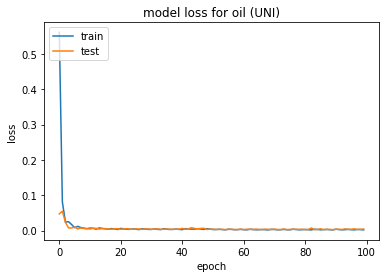

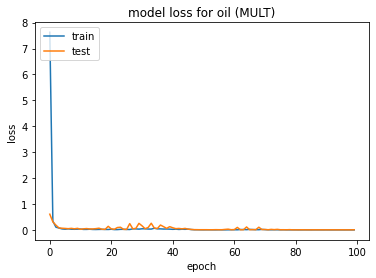

In [69]:
# summarize history for loss
plt.plot(history_oil_uni.history['loss'])
plt.plot(history_oil_uni.history['val_loss'])
plt.title('model loss for oil (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_oil_mult.history['loss'])
plt.plot(history_oil_mult.history['val_loss'])
plt.title('model loss for oil (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

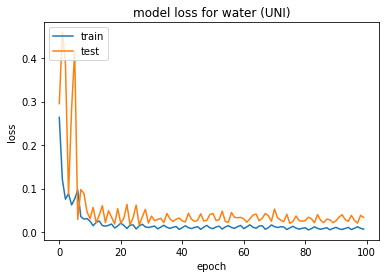

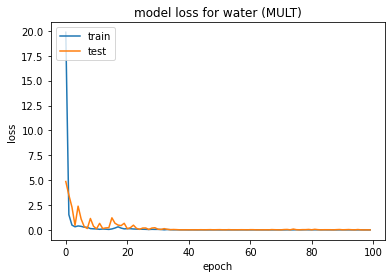

In [70]:
## water
plt.plot(history_water_uni.history['loss'])
plt.plot(history_water_uni.history['val_loss'])
plt.title('model loss for water (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_water_mult.history['loss'])
plt.plot(history_water_mult.history['val_loss'])
plt.title('model loss for water (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

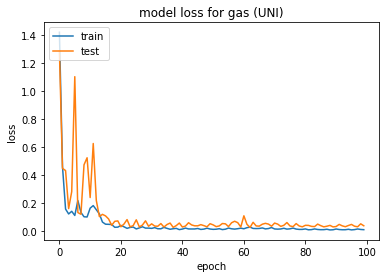

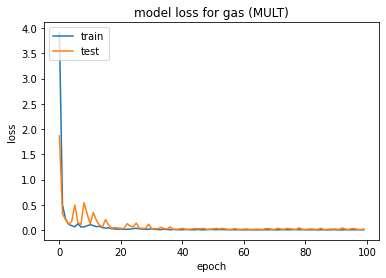

In [71]:
## Gas
plt.plot(history_gas_uni.history['loss'])
plt.plot(history_gas_uni.history['val_loss'])
plt.title('model loss for gas (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history_gas_mult.history['loss'])
plt.plot(history_gas_mult.history['val_loss'])
plt.title('model loss for gas (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
[mse(model_gas_uni.predict(gas_uni_testX).flatten(), gas_uni_testY.flatten()),\
 mse(model_gas_mult.predict(gas_mult_testX).flatten(), gas_mult_testY.flatten()),\
 mse(model_water_uni.predict(water_uni_testX).flatten(), water_uni_testY.flatten()),\
 mse(model_water_mult.predict(water_mult_testX).flatten(), water_mult_testY.flatten()),
 mse(model_oil_uni.predict(oil_uni_testX).flatten(), oil_uni_testY.flatten()),\
 mse(model_oil_mult.predict(oil_mult_testX).flatten(), oil_mult_testY.flatten())]

In [73]:
## gas testing data set visualization
### univariate 
real_gas_uni = gas_uni_testY.flatten()
pred_gas_uni = model_gas_uni.predict(gas_uni_testX).flatten()
df_plot_gas_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_gas_uni['ds']=range(0,len(real_gas_uni))
### multivariate 
real_gas_mult = gas_mult_testY.flatten()
pred_gas_mult = model_gas_mult.predict(gas_mult_testX).flatten()
df_plot_gas_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult, real_gas_mult]))))
df_plot_gas_mult['ds']=range(0,len(real_gas_mult))
## water 
## univariate
real_water_uni = water_uni_testY.flatten()
pred_water_uni = model_water_uni.predict(water_uni_testX).flatten()
df_plot_water_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_uni, real_water_uni]))))
df_plot_water_uni['ds']=range(0,len(real_water_uni))
## multivariate 
real_water_mult = water_mult_testY.flatten()
pred_water_mult = model_water_mult.predict(water_mult_testX).flatten()
df_plot_water_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_mult, real_water_mult]))))
df_plot_water_mult['ds']=range(0,len(real_water_mult))
## oil
## univariate
real_oil_uni = oil_uni_testY.flatten()
pred_oil_uni = model_oil_uni.predict(oil_uni_testX).flatten()
df_plot_oil_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_oil_uni, real_oil_uni]))))
df_plot_oil_uni['ds']=range(0,len(real_oil_uni))
## multivariate 
real_oil_mult = oil_mult_testY.flatten()
pred_oil_mult = model_oil_mult.predict(oil_mult_testX).flatten()
df_plot_oil_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_oil_mult, real_oil_mult]))))
df_plot_oil_mult['ds']=range(0,len(real_oil_mult))

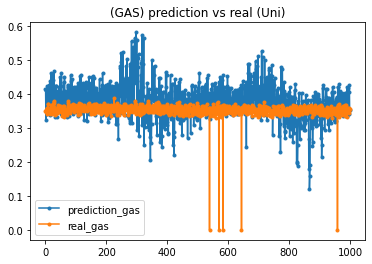

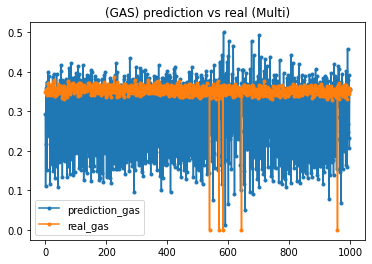

In [74]:
### GAS
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Uni)')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

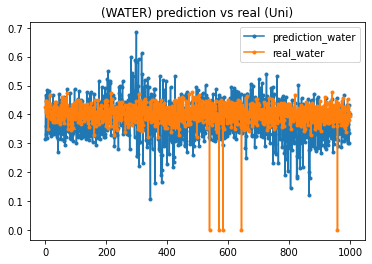

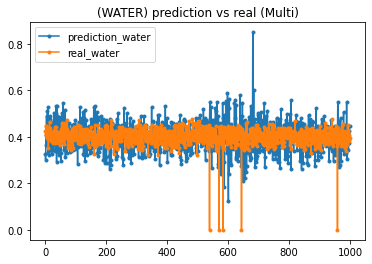

In [75]:
### WATER 
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(WATER) prediction vs real (Uni)')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(WATER) prediction vs real (Multi)')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()

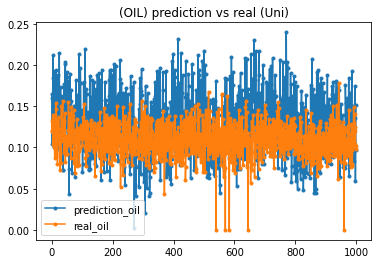

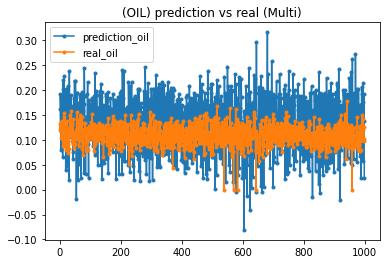

In [76]:
## OIL
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('(OIL) prediction vs real (Uni)')
ax.plot(df_plot_oil_uni['ds'].iloc[start:end], df_plot_oil_uni['prediction'].iloc[start:end], marker=".", label='prediction_oil')
ax.plot(df_plot_oil_uni['ds'].iloc[start:end], df_plot_oil_uni['real'].iloc[start:end], marker=".", label='real_oil')
ax.legend()
fig,ax = plt.subplots()
ax.set_title('(OIL) prediction vs real (Multi)')
ax.plot(df_plot_oil_mult['ds'].iloc[start:end], df_plot_oil_mult['prediction'].iloc[start:end], marker=".", label='prediction_oil')
ax.plot(df_plot_oil_mult['ds'].iloc[start:end], df_plot_oil_mult['real'].iloc[start:end], marker=".", label='real_oil')
ax.legend()